In [39]:
import os
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [40]:
# Set dataset path
dataset_path = "/Users/kundansingh/Desktop/untitledfolder/DL/casestudy2/food"  # Replace with your dataset path

# Load and preprocess dataset
def preprocess_image(image):
    """Resize and normalize image to [-1, 1] for GANs."""
    image = tf.image.resize(image, [64, 64])  # Resize to 64x64
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(batch_size=32):
    """Load and preprocess images from directory."""
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        label_mode=None,
        image_size=(64, 64),
        batch_size=batch_size,
        shuffle=True,
    )
    dataset = dataset.map(preprocess_image)
    return dataset

# Hyperparameters
BUFFER_SIZE = 60000
BATCH_SIZE = 64
LATENT_DIM = 100
EPOCHS = 5

# Load dataset
dataset = load_dataset(batch_size=BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 108047 files.


In [41]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1),
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Define the Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"),
    ])
    return model

generator = build_generator()
generator.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [43]:
# Define loss functions and Adam optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)


In [44]:
# Define the GAN Model
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, LATENT_DIM])

        # Train Generator
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Train Discriminator
        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}


In [45]:
# Instantiate and compile the GAN
gan = GAN(generator=generator, discriminator=discriminator)
gan.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    loss_fn=cross_entropy
)

# Train the GAN
history = gan.fit(dataset, epochs=EPOCHS)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 494s 290ms/step - disc_loss: 1.2256 - gen_loss: 0.8664
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 494s 291ms/step - disc_loss: 1.1213 - gen_loss: 0.9973
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 489s 288ms/step - disc_loss: 1.0119 - gen_loss: 1.1530
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 500s 294ms/step - disc_loss: 0.8572 - gen_loss: 1.4021
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 495s 291ms/step - disc_loss: 0.7910 - gen_loss: 1.6062


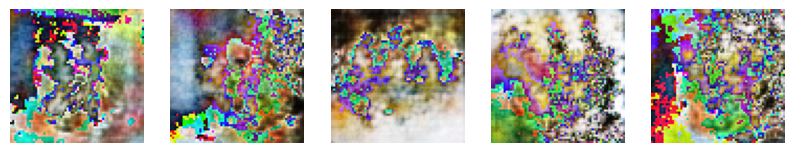

In [46]:
import numpy as np
from tensorflow.keras.utils import array_to_img

# Number of images to generate
num_images = 5

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

# Use the generator to create fake images
generated_images = generator(random_latent_vectors)

# Denormalize the images to bring them back to [0, 255] range
generated_images = (generated_images * 255).numpy().astype("uint8")

# Visualize the generated images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(array_to_img(generated_images[i]))
    plt.axis("off")
plt.show()